## <center> PREVISÃO DO TEMPO DE SÍNTESE DE MOF's <br><br> Regressão por Floresta Aleatória 🌳🌲🌴 </center>

Projeto final da disciplina `Aprendizado de Máquina` do 2° período do Bacharelado em `Ciência e Tecnologia` da *Ilum Escola de Ciência (Centro Nacional de Pesquisa em Energia e Materiais)*.

<b> Professor: </b> Daniel Cassar<br>
<b> Semestre: </b> 2024.2 <br>
<b> Turma: </b> 2024 <br>
<b> Grupo: </b> 6 - Arautos da Crepúsculo <br>
<b> Integrantes: </b> Feérica Lyra (*Letícia Nunes*), Mística Luz (*Rafaela Luz*) e Druida Thomaleq (*Thomas Hannemann*) <br>

<div class='alert alert-warning'>
    <b>ATENÇÃO</b>
    
Este programa possui uma célula de código custosa computacionalmente na seção 4. Por isso, recomenda-se o uso de um **HPC** para rodar este caderno. Na falta deste, do tempo ou qualquer recurso para rodar o programa no seu computador, é possível obter os arquivos gerados aqui também no nosso GitHub. Todavia, caso precise rodar esse programa sem HPC, o programa ainda irá rodar em menos que 1h.
</div>

---

### Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Criação do modelo
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Otimização de hiperparâmetros
from optuna import create_study
from sklearn.model_selection import cross_val_score

SEMENTE_ALETORIA = 84920

### Sumário

1. Introdução 
2. Preparações Iniciais
3. Floresta Aleatória <br>
    3.1. Modelo e métricas <br>
    3.2. Importância dos atributos <br>
4. Otimização de hiperparâmetros
5. Conclusão
6. Referências

---

## 1. Introdução

Neste caderno, iremos realizar uma regressão utilizando o algoritmo de floresta aleatória do SciKit Learn, como uma das tentativas de se obter um modelo com alta performance. 

Floresta aleatória é um algoritmo que, como o nome sugere, funciona de forma semelhante ao árvore de decisão. Todavia, a diferença entre a floresta e a árvore de decisão é que treinamos diversas árvores, expostas a conjuntos de dados sutilmente diferentes (um sorteio com reposição, por exemplo), de um mesmo DataFrame. Assim, espera-se uma melhora na performance quando as "parcialidades" de cada árvore são consideradas em conjunto. A diferença faz a força!

## 2. Preparações iniciais

Como todo algoritmo de machine learning, precisamos carregar nossos dados e definir nosso target (tempo) e os atributos (X).

Carregando os DataFrames de treino e teste.

In [2]:
df_treino = pd.read_csv('RAC_treino_floresta.csv')
df_teste = pd.read_csv('RAC_teste_floresta.csv')

Agora, podemos definir nosso target (y) e atributos (X) de treino e teste.

In [3]:
X_treino = df_treino.drop('time', axis=1)
y_treino = df_treino['time'].ravel()

X_teste = df_teste.drop('time', axis=1)
y_teste = df_teste['time'].ravel()

## 3. Floresta Aleatória 

### 3.1. Modelo e Métricas

Agora, iremos instanciar o modelo `RandomForestRegressor` como `modelo_fa`.

In [4]:
modelo_fa = RandomForestRegressor()

Com os hiperparâmetros padronizados e arbitrários, definidos pelo próprio SciKit Learn, podemos ajustá-lo aos nossos dados.

In [5]:
modelo_fa.fit(X_treino, y_treino)

RandomForestRegressor()

Realizando uma previsão!

In [6]:
y_previsao = modelo_fa.predict(X_teste)

Encontrando as métricas (*MSE* e *RMSE*):

In [7]:
y_verdadeiro = y_teste

MSE = mean_squared_error(y_verdadeiro, y_previsao)
RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared = False)

print(f"O MSE do modelo árvore de decisão foi de {MSE}.")
print(f"O RMSE do modelo árvore de decisão foi de {RMSE} horas.")

O MSE do modelo árvore de decisão foi de 3834.8813703703718.
O RMSE do modelo árvore de decisão foi de 61.926419001669814 horas.


Legal! Mas não tão legal quanto pode ser. Podemos encontrar a melhor combinação de hiperparâmetros para encontrar o menor erro - por isso, iremos realizar a otimização um pouco mais a frente.

### 3.2. Importâncias dos atributos

O algoritmo de floresta aleatória nos proporciona algumas características sobre nossos dados que nem sempre é tão fácil identificar com outros métodos. Aqui, podemos identificar a importância relativa de cada atributo - quanto cada atributo "pesa" no momento de realizar decisões. Aqui, iremos computar esses valores apenas como uma observação.

Com o modelo do Sci-Kit Learn, obtemos a importância relativa apenas usando o método `.feature_importances_`.

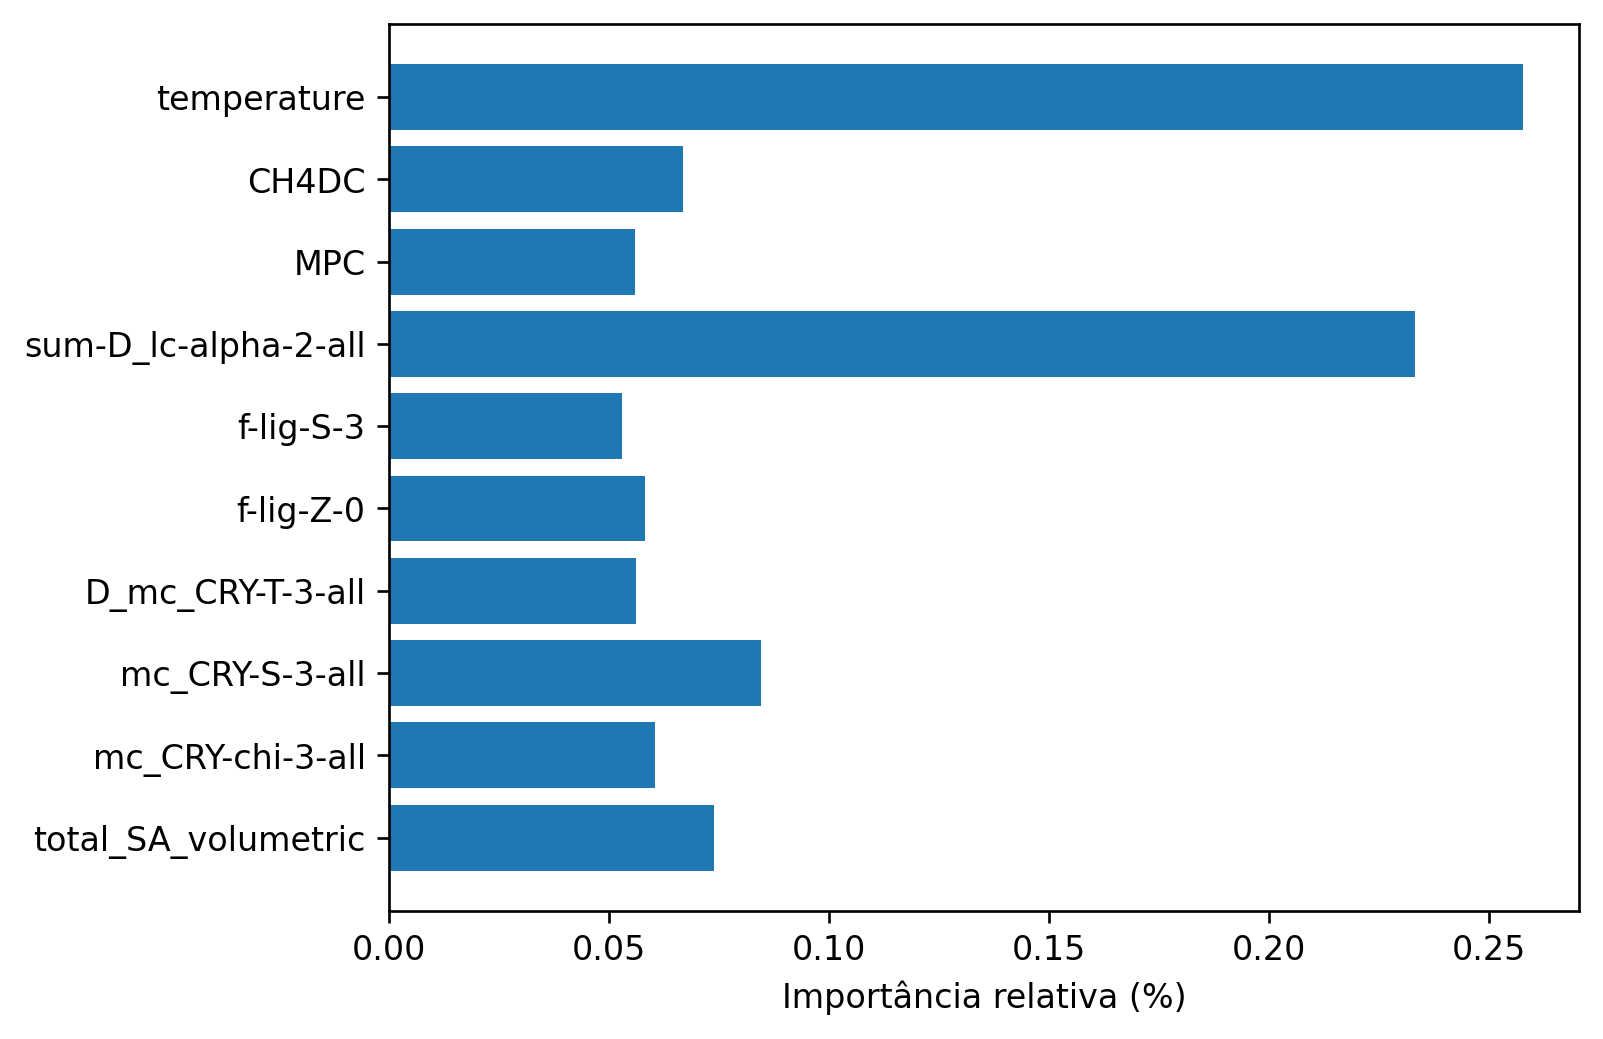

In [9]:
plt.figure(dpi=240)

FEATURES=X_treino.columns

importancia = modelo_fa.feature_importances_
plt.barh(y=FEATURES, width=importancia)

plt.xlabel("Importância relativa (%)");

Conseguimos observar que a temperatura, em especial tem a maior influência na previsão do tempo de reação - como geralmente é considerada por químicos na preparação da reação. Todavia, em relação aos outros valores, a linha de pensamento nem sempre nos leva a considerá-los, sua relevância não é tão intuitiva assim.

## 4. Otimização de hiperparâmetros

Utilizando a biblioteca Optuna, faremos a otimização dos hiperparâmetros.

Criando a função para instanciar o modelo:

In [10]:
def cria_instancia_modelo(trial): 
    """Cria uma instância do modelo.

    Args:
      trial: objeto tipo Trial do optuna.

    Returns:
      Uma instância do modelo desejado.

    """
    parametros = {
        "n_estimators": trial.suggest_int("num_arvores", 10, 100, log=True), 
        "criterion": trial.suggest_categorical(
            "critério", ["squared_error", "friedman_mse", "poisson"]
        ),
        "min_samples_split": trial.suggest_int(      
            "min_exemplos_split", 2, 20, log=True 
        ),
        "min_samples_leaf": trial.suggest_int(
            "min_exemplos_folha", 1, 20, log=True
        ),
        "max_features": trial.suggest_float("num_max_atributos", 0, 1),
        "n_jobs": -1,
        "bootstrap": True,
        "random_state": SEMENTE_ALETORIA,
    }

    model = RandomForestRegressor(**parametros)

    return model

Com isso, conseguimos definir nossa função objetivo, que terá como métrica de avaliação sendo a validação cruzada, usando a função `cross_val_score` do Sci-Kit Learn:

In [11]:
def funcao_objetivo(trial, X, y, num_folds):
    """Função objetivo do optuna

    Referencia:
      https://medium.com/@walter_sperat/ using-optuna-with-sklearn-the-right-way-part-1-6b4ad0ab2451

    """
    modelo = cria_instancia_modelo(trial)

    metricas = cross_val_score(
        modelo,
        X,
        y, 
        scoring="neg_root_mean_squared_error",
        cv=num_folds,
    )

    return -metricas.mean() 

Feito a função objetivo, criamos nosso objeto de estudo, que é onde será realizado todo o processo de otimização. A métrica utilizada aqui, como nos cadernos anteriores, é RMSE.

In [12]:
NOME_DO_ESTUDO = "floresta_aleatoria_MOFs"

objeto_de_estudo = create_study(
    direction="minimize",
    study_name=NOME_DO_ESTUDO,
    storage=f"sqlite:///{NOME_DO_ESTUDO}.db",
    load_if_exists=True,
)

[I 2024-10-21 01:24:44,507] A new study created in RDB with name: floresta_aleatoria_MOFs


Agora, apenas precisamos definir uma função objetivo de forma que recebe apenas um argumento (devido ao funcionamento do método do Optuna). Especificamos aqui a `funcao_objetivo` com os argumentos que utilizaremos. Apesar do custo computacional mais elevado, o número de folds escolhido para a validação cruzada é considerado muito bom para a estimativa de performance.

In [13]:
NUM_FOLDS = 10

def funcao_objetivo_parcial(trial):
    return funcao_objetivo(trial, X_treino, y_treino, NUM_FOLDS)

Com isso, vamos finalmente realizar a otimização:

In [14]:
NUM_TENTATIVAS = 150 # É cumulativo em relação aos já feitos no arquivo

objeto_de_estudo.optimize(funcao_objetivo_parcial, n_trials=NUM_TENTATIVAS)

[I 2024-10-21 01:24:51,627] Trial 0 finished with value: 39.84685773554287 and parameters: {'num_arvores': 54, 'critério': 'friedman_mse', 'min_exemplos_split': 3, 'min_exemplos_folha': 1, 'num_max_atributos': 0.45270826035319256}. Best is trial 0 with value: 39.84685773554287.
[I 2024-10-21 01:24:52,487] Trial 1 finished with value: 43.86652459140878 and parameters: {'num_arvores': 40, 'critério': 'friedman_mse', 'min_exemplos_split': 3, 'min_exemplos_folha': 6, 'num_max_atributos': 0.1937882606024136}. Best is trial 0 with value: 39.84685773554287.
[I 2024-10-21 01:24:53,786] Trial 2 finished with value: 39.58153259633322 and parameters: {'num_arvores': 44, 'critério': 'squared_error', 'min_exemplos_split': 4, 'min_exemplos_folha': 1, 'num_max_atributos': 0.8330856121104075}. Best is trial 2 with value: 39.58153259633322.
[I 2024-10-21 01:24:54,356] Trial 3 finished with value: 39.93814109589498 and parameters: {'num_arvores': 13, 'critério': 'poisson', 'min_exemplos_split': 2, 'min_

[I 2024-10-20 23:34:27,643] Trial 61 finished with value: 44.807369928383295 and parameters: {'num_arvores': 76, 'critério': 'friedman_mse', 'min_exemplos_split': 18, 'min_exemplos_folha': 17, 'num_max_atributos': 0.9973983403474787}. Best is trial 56 with value: 38.80207445031849.
[I 2024-10-20 23:34:31,146] Trial 62 finished with value: 38.829556991036526 and parameters: {'num_arvores': 61, 'critério': 'friedman_mse', 'min_exemplos_split': 15, 'min_exemplos_folha': 1, 'num_max_atributos': 0.9111900983258341}. Best is trial 56 with value: 38.80207445031849.
[I 2024-10-20 23:34:34,907] Trial 63 finished with value: 39.10061181706497 and parameters: {'num_arvores': 61, 'critério': 'friedman_mse', 'min_exemplos_split': 15, 'min_exemplos_folha': 1, 'num_max_atributos': 0.8319492020515149}. Best is trial 56 with value: 38.80207445031849.
[I 2024-10-20 23:34:38,239] Trial 64 finished with value: 39.1619187916987 and parameters: {'num_arvores': 54, 'critério': 'friedman_mse', 'min_exemplos_s

[I 2024-10-20 23:36:00,668] Trial 91 finished with value: 44.45626302552613 and parameters: {'num_arvores': 43, 'critério': 'friedman_mse', 'min_exemplos_split': 10, 'min_exemplos_folha': 14, 'num_max_atributos': 0.9502308463837766}. Best is trial 85 with value: 38.69853153593466.
[I 2024-10-20 23:36:03,143] Trial 92 finished with value: 45.088539153777575 and parameters: {'num_arvores': 40, 'critério': 'friedman_mse', 'min_exemplos_split': 15, 'min_exemplos_folha': 20, 'num_max_atributos': 0.9296028648431075}. Best is trial 85 with value: 38.69853153593466.
[I 2024-10-20 23:36:06,304] Trial 93 finished with value: 38.785045199862125 and parameters: {'num_arvores': 44, 'critério': 'friedman_mse', 'min_exemplos_split': 17, 'min_exemplos_folha': 1, 'num_max_atributos': 0.9856534967348692}. Best is trial 85 with value: 38.69853153593466.
[I 2024-10-20 23:36:09,133] Trial 94 finished with value: 38.934245491297474 and parameters: {'num_arvores': 35, 'critério': 'friedman_mse', 'min_exemplo

[I 2024-10-20 23:37:24,998] Trial 121 finished with value: 38.94522173683813 and parameters: {'num_arvores': 45, 'critério': 'friedman_mse', 'min_exemplos_split': 18, 'min_exemplos_folha': 1, 'num_max_atributos': 0.8933601869169642}. Best is trial 85 with value: 38.69853153593466.
[I 2024-10-20 23:37:27,839] Trial 122 finished with value: 38.77894127099911 and parameters: {'num_arvores': 38, 'critério': 'friedman_mse', 'min_exemplos_split': 20, 'min_exemplos_folha': 1, 'num_max_atributos': 0.9831388104030091}. Best is trial 85 with value: 38.69853153593466.
[I 2024-10-20 23:37:30,632] Trial 123 finished with value: 38.859358825843444 and parameters: {'num_arvores': 37, 'critério': 'friedman_mse', 'min_exemplos_split': 20, 'min_exemplos_folha': 1, 'num_max_atributos': 0.9629082760832597}. Best is trial 85 with value: 38.69853153593466.
[I 2024-10-20 23:37:33,392] Trial 124 finished with value: 38.97094003272713 and parameters: {'num_arvores': 35, 'critério': 'friedman_mse', 'min_exemplo

Podemos resgatar os parâmetros do melhor resultado com `best_trial`:

In [15]:
melhor_trial = objeto_de_estudo.best_trial

print(f"Número do melhor trial: {melhor_trial.number}")
print(f"Parâmetros do melhor trial: {melhor_trial.params}")
print(f"RMSE do melhor trial: {melhor_trial.value}")

Número do melhor trial: 111
Parâmetros do melhor trial: {'num_arvores': 50, 'critério': 'friedman_mse', 'min_exemplos_split': 17, 'min_exemplos_folha': 1, 'num_max_atributos': 0.9777417834421356}
RMSE do melhor trial: 38.6947222091576


Agora, podemos treinar um modelo com esses hiperparâmetros e realizar uma previsão com os dados de treino. Note que haverá uma diferença ao valor de RMSE encontrado pelo Optuna, devido a essa mudança de dados de teste.

In [16]:
modelo = cria_instancia_modelo(melhor_trial)

modelo.fit(X_treino, y_treino)

y_verdadeiro = y_teste
X_verdadeiro = X_teste

y_previsao = modelo.predict(X_verdadeiro)

RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared = False)

print(RMSE)

61.035985285831146


O valor de RMSE está menor que o inicialmente encontrado com valores arbitrários, entretanto, discrepante com o resultado encontrado pelo Optuna. Não encontramos nada que indicasse o motivo dessa diferença, apenas a mudança dos dados de teste. Por isso, levamos em consideração a possibilidade de um overfitting, dado à especifidade ao dados a métrica do RMSE.

## 5. Conclusão

O algoritmo de floresta aleatória teve um valor de RMSE maior que o esperado, mesmo otimizado. Acreditamos que tenha acontecido um overfitting, apesar de não tenha sido encontrados erros na construção do código de otimização. 🫤

Contudo, ainda com esse algoritmo conseguimos extrair outras informações relevantes, que não foram vistas em outros, como em que a relação de importância entre os atributos se deu.

## 6. Referências

1. <b>Construção de um algoritmo de floresta aleatória</b>: ATP-203 5.1 - Floresta aleatória (notebook didático feito por Daniel Cassar)
2. <b>Otimização de hiperparâmetros com Optuna</b>: <br>
    2.1. https://ryannolandata.com/optuna-hyperparameter-tuning/ <br>
    2.2. https://medium.com/@walter_sperat/using-optuna-with-sklearn-the-right-way-part-1-6b4ad0ab2451 <br>
    2.3. ATP-203 6.1 - Otimização de hiperparâmetros com optuna (notebook didático feito por Daniel Cassar) <br>
3. <b>Gráfico de barras</b>: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.barh.html#matplotlib.pyplot.barh